In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [4]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [5]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [6]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


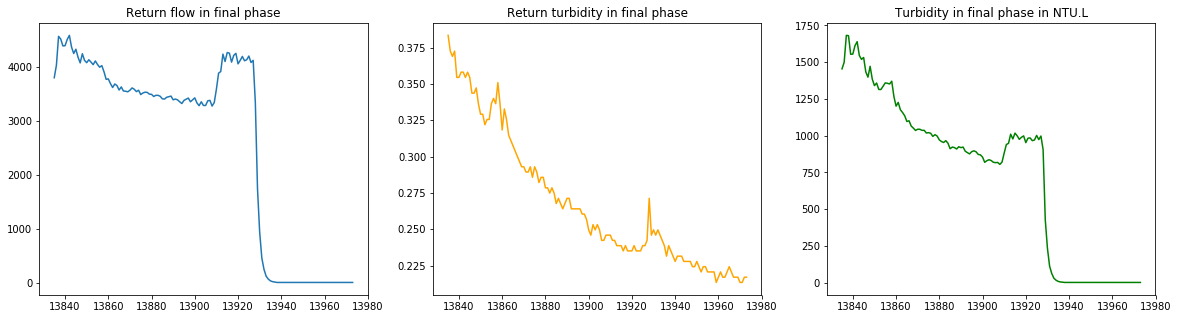

In [7]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

# Попробуем посмотреть на данные. Возможно, получится увидеть некоторые закономерности

In [8]:
import time
import csv
import pickle
import random
import time
import pylab as plt
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)


Populating the interactive namespace from numpy and matplotlib


In [9]:
train_data_ts = train_data.copy()
train_data_ts.index = train_data_ts['timestamp']

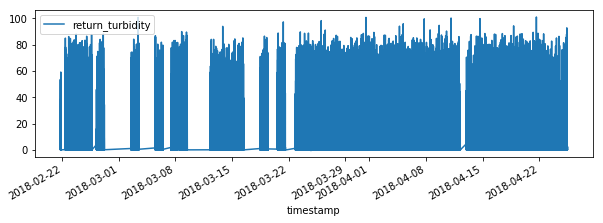

In [10]:
train_data_ts[['return_turbidity']].plot()

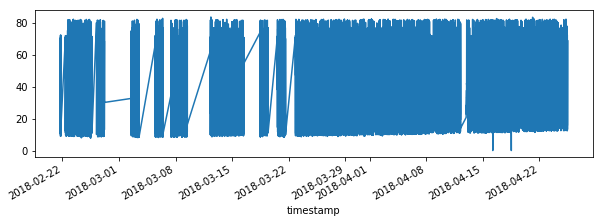

In [11]:
train_data_ts[train_data_ts['phase'] == 'final_rinse']['return_temperature'].plot()

In [20]:
train_data = train_data[train_data['phase'] != 'final_rinse']

In [21]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [22]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

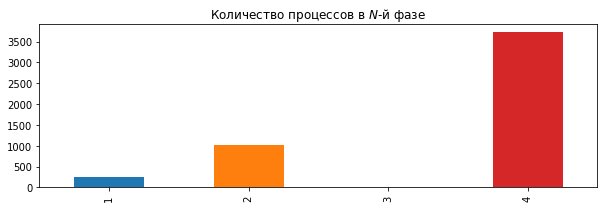

In [23]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

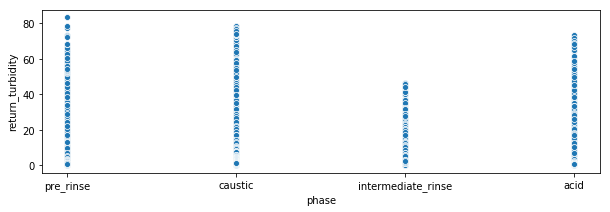

In [24]:
sns.scatterplot(train_data['phase'].head(100000), train_data['return_turbidity'].head(100000))

In [25]:
train_data

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,True,True,False,False,False,False,False,False,True,True,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,True,True,False,False,False,False,False,False,True,True,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,True,True,False,False,False,False,False,False,True,True,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,True,True,False,False,False,False,False,False,True,True,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,True,True,False,False,False,False,False,False,True,True,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,45.398197,44.334373,False,0.0,False,0.0,False
5,20001,405,pre_rinse,2018-04-15 04:20:57,L4,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,True,True,False,False,False,False,False,False,True,True,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,45.385914,44.336000,False,0.0,False,0.0,False
6,20001,405,pre_rinse,2018-04-15 04:20:59,L4,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,True,True,False,False,False,False,False,False,True,True,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,45.369984,44.332523,False,0.0,False,0.0,False
7,20001,405,pre_rinse,2018-04-15 04:21:01,L4,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,True,True,False,False,False,False,False,False,True,True,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,45.381107,44.336490,False,0.0,False,0.0,False
8,20001,405,pre_rinse,2018-04-15 04:21:03,L4,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,True,True,False,False,False,False,False,False,True,True,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,45.402290,44.334263,False,0.0,False,0.0,False


### Создадим уникальный индентификатор фазы для каждого процесса:


In [26]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(13)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

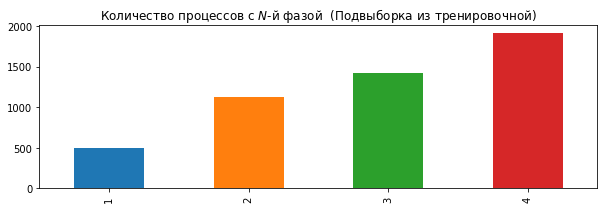

In [27]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [28]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000)).index.nunique()

6

In [29]:
#train_limited_with_phases_gr = train_limited.head(15).copy()
#phases = ['acid', 'caustic', 'pre_rinse']
#cols = train_limited_with_phases_gr.columns
#for col in cols[3:]:
#    for process in train_limited_with_phases_gr['process_id'].unique():
#        for phase in phases:
#            train_limited_with_phases_gr[col + '_' + phase] = train_limited[col][(train_limited['process_id'] == process) & (train_limited['phase'] == phase)]

## Удалим процессы, object_id которых не присутствует в тестовой выборке.

In [30]:
different_objects = []
for object_id in train_data['object_id'].unique():
    if object_id not in test_data['object_id'].unique():
        different_objects.append(object_id)
different_objects

[971, 976, 910, 970, 920, 977]

In [31]:
train_limited = train_limited[~(train_limited['object_id'].isin(different_objects))]

In [32]:
train_labels = train_labels.loc[train_limited.process_id.unique()]

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [33]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
def models_validation(X, y, models, folds):
    tsCV = KFold(folds)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, n_jobs=-1, cv= tsCV)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

## Преобразуем данные: 

In [47]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'timestamp',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]
ts_cols_my = [
    'process_id',
    'phase',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

## Преобразуем признаки временного ряда

In [67]:
import scipy as sc
def perc0_25_mean(x):
    size = shape(x)[0]
    size = round(size * 0.25)
    return x[:size].mean()

def perc15_40_mean(x):
    size = shape(x)[0]
    size1 = round(size * 0.15)
    size2 = round(size* 0.4)
    return x[size1:size2].mean()

def perc30_65_mean(x):
    size = shape(x)[0]
    size1 = round(size * 0.3)
    size2 = round(size* 0.65)
    return x[size1:size2].mean()

def perc50_80_mean(x):
    size = shape(x)[0]
    size1 = round(size * 0.5)
    size2 = round(size* 0.8)
    return x[size1:size2].mean()

def perc75_100_mean(x):
    size = shape(x)[0]
    size1 = round(size * 0.75)
    size2 = round(size)
    return x[size1:size2].mean()

def tail50mean(x):
    return x.tail(50).mean()

def invboxcox(x):
    lmb = 0.59
    return np.exp(np.log(lmb*x.tail(1)+1)/lmb)

def var_log(x):
    return np.var(np.log(x + np.abs(np.min(x)) + 1))


def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    df = df.sort_values(by=["process_id", "timestamp"], ascending=True)
    #Длительность каждого процесса.
    duration_of_process = df.groupby('process_id')["timestamp"].max() - df.groupby('process_id')["timestamp"].min() 
    duration_of_process = duration_of_process.dt.total_seconds()
    object_id = df.groupby('process_id')['object_id'].mean() #Надеемся, что все процессы обрабатывают один объект
    
    ts_df = df[ts_cols].set_index('process_id')
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                             perc0_25_mean,
                                                #             perc15_40_mean,
                                                 #            perc30_65_mean,
                                                  #           perc75_100_mean,
                                                             tail50mean,
                                                       #     var_log,
                                                             
                                                             'sum', 'mad'])
    ts_features_df = pd.concat([duration_of_process, object_id, ts_features], axis = 1)
    
    return ts_features_df

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

,timestamp,object_id,"(supply_flow, min)","(supply_flow, max)","(supply_flow, mean)","(supply_flow, std)","(supply_flow, perc0_25_mean)","(supply_flow, tail50mean)","(supply_flow, sum)","(supply_flow, mad)","(supply_pressure, min)","(supply_pressure, max)","(supply_pressure, mean)","(supply_pressure, std)","(supply_pressure, perc0_25_mean)","(supply_pressure, tail50mean)","(supply_pressure, sum)","(supply_pressure, mad)","(return_temperature, min)","(return_temperature, max)","(return_temperature, mean)","(return_temperature, std)","(return_temperature, perc0_25_mean)","(return_temperature, tail50mean)","(return_temperature, sum)","(return_temperature, mad)","(return_conductivity, min)","(return_conductivity, max)","(return_conductivity, mean)","(return_conductivity, std)","(return_conductivity, perc0_25_mean)","(return_conductivity, tail50mean)","(return_conductivity, sum)","(return_conductivity, mad)","(return_turbidity, min)","(return_turbidity, max)","(return_turbidity, mean)","(return_turbidity, std)","(return_turbidity, perc0_25_mean)","(return_turbidity, tail50mean)","(return_turbidity, sum)","(return_turbidity, mad)","(return_flow, min)","(return_flow, max)","(return_flow, mean)","(return_flow, std)","(return_flow, perc0_25_mean)","(return_flow, tail50mean)","(return_flow, sum)","(return_flow, mad)","(tank_level_pre_rinse, min)","(tank_level_pre_rinse, max)","(tank_level_pre_rinse, mean)","(tank_level_pre_rinse, std)","(tank_level_pre_rinse, perc0_25_mean)","(tank_level_pre_rinse, tail50mean)","(tank_level_pre_rinse, sum)","(tank_level_pre_rinse, mad)","(tank_level_caustic, min)","(tank_level_caustic, max)","(tank_level_caustic, mean)","(tank_level_caustic, std)","(tank_level_caustic, perc0_25_mean)","(tank_level_caustic, tail50mean)","(tank_level_caustic, sum)","(tank_level_caustic, mad)","(tank_level_acid, min)","(tank_level_acid, max)","(tank_level_acid, mean)","(tank_level_acid, std)","(tank_level_acid, perc0_25_mean)","(tank_level_acid, tail50mean)","(tank_level_acid, sum)","(tank_level_acid, mad)","(tank_level_clean_water, min)","(tank_level_clean_water, max)","(tank_level_clean_water, mean)","(tank_level_clean_water, std)","(tank_level_clean_water, perc0_25_mean)","(tank_level_clean_water, tail50mean)","(tank_level_clean_water, sum)","(tank_level_clean_water, mad)","(tank_temperature_pre_rinse, min)","(tank_temperature_pre_rinse, max)","(tank_temperature_pre_rinse, mean)","(tank_temperature_pre_rinse, std)","(tank_temperature_pre_rinse, perc0_25_mean)","(tank_temperature_pre_rinse, tail50mean)","(tank_temperature_pre_rinse, sum)","(tank_temperature_pre_rinse, mad)","(tank_temperature_caustic, min)","(tank_temperature_caustic, max)","(tank_temperature_caustic, mean)","(tank_temperature_caustic, std)","(tank_temperature_caustic, perc0_25_mean)","(tank_temperature_caustic, tail50mean)","(tank_temperature_caustic, sum)","(tank_temperature_caustic, mad)","(tank_temperature_acid, min)","(tank_temperature_acid, max)","(tank_temperature_acid, mean)","(tank_temperature_acid, std)","(tank_temperature_acid, perc0_25_mean)","(tank_temperature_acid, tail50mean)","(tank_temperature_acid, sum)","(tank_temperature_acid, mad)","(tank_concentration_caustic, min)","(tank_concentration_caustic, max)","(tank_concentration_caustic, mean)","(tank_concentration_caustic, std)","(tank_concentration_caustic, perc0_25_mean)","(tank_concentration_caustic, tail50mean)","(tank_concentration_caustic, sum)","(tank_concentration_caustic, mad)","(tank_concentration_acid, min)","(tank_concentration_acid, max)","(tank_concentration_acid, mean)","(tank_concentration_acid, std)","(tank_concentration_acid, perc0_25_mean)","(tank_concentration_acid, tail50mean)","(tank_concentration_acid, sum)","(tank_concentration_acid, mad)"
process_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20001,2848.0,405,47.019676,59396.703,50103.211842,11397.417702,45297.606862,54254.34044,6.814037

In [68]:
import scipy as sc
def tail50mean(x):
    return x.tail(50).mean()

def tail30std(x):
    return x.tail(30).std()

def tail30median(x):
    return x.tail(30).median()



def prep_time_series_features_my(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols_my].set_index('process_id')
    phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby(['process_id', 'phase']).aggregate(['min', 'max', 'mean', 'std',
                                                             tail50mean,
                                                             'mad',
                                                             'sum'
                                                        ])
    ts_features_sep_phases = pd.DataFrame(ts_df.index.unique())
    ts_features = ts_features.reset_index(level=[0,1])
    ts_features.index = ts_features['process_id']
    ts_features.pop('process_id')
    ts_features_sep_phases.index = ts_features_sep_phases['process_id']
    ts_features_sep_phases.pop('process_id')
    # Для каждой фазы процесса будут отдельные характеристики:
    for col in ts_features.columns[1:]:
        for phase in phases:
            ts_features_sep_phases[str(col) + '_' + phase] = ts_features[col][ts_features['phase'] == phase]
    for col in ts_features_sep_phases.columns:
        ts_features_sep_phases[col].fillna(value = ts_features_sep_phases[col].mean(), inplace = True)
    #ts_features_sep_phases.fillna(value = -5000, inplace=True)
    return ts_features_sep_phases

# show example for first 5,000 observations
train_features_check = prep_time_series_features_my(train_limited.head(5000), columns=ts_cols)

In [69]:
train_features_check

,"('supply_flow', 'min')_pre_rinse","('supply_flow', 'min')_caustic","('supply_flow', 'min')_intermediate_rinse","('supply_flow', 'min')_acid","('supply_flow', 'max')_pre_rinse","('supply_flow', 'max')_caustic","('supply_flow', 'max')_intermediate_rinse","('supply_flow', 'max')_acid","('supply_flow', 'mean')_pre_rinse","('supply_flow', 'mean')_caustic","('supply_flow', 'mean')_intermediate_rinse","('supply_flow', 'mean')_acid","('supply_flow', 'std')_pre_rinse","('supply_flow', 'std')_caustic","('supply_flow', 'std')_intermediate_rinse","('supply_flow', 'std')_acid","('supply_flow', 'tail50mean')_pre_rinse","('supply_flow', 'tail50mean')_caustic","('supply_flow', 'tail50mean')_intermediate_rinse","('supply_flow', 'tail50mean')_acid","('supply_flow', 'mad')_pre_rinse","('supply_flow', 'mad')_caustic","('supply_flow', 'mad')_intermediate_rinse","('supply_flow', 'mad')_acid","('supply_flow', 'sum')_pre_rinse","('supply_flow', 'sum')_caustic","('supply_flow', 'sum')_intermediate_rinse","('supply_flow', 'sum')_acid","('supply_pressure', 'min')_pre_rinse","('supply_pressure', 'min')_caustic","('supply_pressure', 'min')_intermediate_rinse","('supply_pressure', 'min')_acid","('supply_pressure', 'max')_pre_rinse","('supply_pressure', 'max')_caustic","('supply_pressure', 'max')_intermediate_rinse","('supply_pressure', 'max')_acid","('supply_pressure', 'mean')_pre_rinse","('supply_pressure', 'mean')_caustic","('supply_pressure', 'mean')_intermediate_rinse","('supply_pressure', 'mean')_acid","('supply_pressure', 'std')_pre_rinse","('supply_pressure', 'std')_caustic","('supply_pressure', 'std')_intermediate_rinse","('supply_pressure', 'std')_acid","('supply_pressure', 'tail50mean')_pre_rinse","('supply_pressure', 'tail50mean')_caustic","('supply_pressure', 'tail50mean')_intermediate_rinse","('supply_pressure', 'tail50mean')_acid","('supply_pressure', 'mad')_pre_rinse","('supply_pressure', 'mad')_caustic","('supply_pressure', 'mad')_intermediate_rinse","('supply_pressure', 'mad')_acid","('supply_pressure', 'sum')_pre_rinse","('supply_pressure', 'sum')_caustic","('supply_pressure', 'sum')_intermediate_rinse","('supply_pressure', 'sum')_acid","('return_temperature', 'min')_pre_rinse","('return_temperature', 'min')_caustic","('return_temperature', 'min')_intermediate_rinse","('return_temperature', 'min')_acid","('return_temperature', 'max')_pre_rinse","('return_temperature', 'max')_caustic","('return_temperature', 'max')_intermediate_rinse","('return_temperature', 'max')_acid","('return_temperature', 'mean')_pre_rinse","('return_temperature', 'mean')_caustic","('return_temperature', 'mean')_intermediate_rinse","('return_temperature', 'mean')_acid","('return_temperature', 'std')_pre_rinse","('return_temperature', 'std')_caustic","('return_temperature', 'std')_intermediate_rinse","('return_temperature', 'std')_acid","('return_temperature', 'tail50mean')_pre_rinse","('return_temperature', 'tail50mean')_caustic","('return_temperature', 'tail50mean')_intermediate_rinse","('return_temperature', 'tail50mean')_acid","('return_temperature', 'mad')_pre_rinse","('return_temperature', 'mad')_caustic","('return_temperature', 'mad')_intermediate_rinse","('return_temperature', 'mad')_acid","('return_temperature', 'sum')_pre_rinse","('return_temperature', 'sum')_caustic","('return_temperature', 'sum')_intermediate_rinse","('return_temperature', 'sum')_acid","('return_conductivity', 'min')_pre_rinse","('return_conductivity', 'min')_caustic","('return_conductivity', 'min')_intermediate_rinse","('return_conductivity', 'min')_acid","('return_conductivity', 'max')_pre_rinse","('return_conductivity', 'max')_caustic","('return_conductivity', 'max')_intermediate_rinse","('return_conductivity', 'max')_acid","('return_conductivity', 'mean')_pre_rinse","('return_conductivity', 'mean')_caustic","('return_conductivity', 'mean')_intermediate_rinse","('return_conductivity', 'mean')_acid","('return_conductivity', 'std')_pre_rinse","('return_conductivity', 'std')_caustic","('

In [70]:
def create_feature_matrix(df, flag):
    metadata = prep_metadata(df)
    if flag == 0:
        time_series = prep_time_series_features(df)
    else:
        time_series = prep_time_series_features_my(df)
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    
    return feature_matrix

In [71]:
train_features = create_feature_matrix(train_limited, 0)

In [72]:
train_features.head(10)

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,pipeline_L12,num_phases,timestamp,object_id,"(supply_flow, min)","(supply_flow, max)","(supply_flow, mean)","(supply_flow, std)","(supply_flow, perc0_25_mean)","(supply_flow, tail50mean)","(supply_flow, sum)","(supply_flow, mad)","(supply_pressure, min)","(supply_pressure, max)","(supply_pressure, mean)","(supply_pressure, std)","(supply_pressure, perc0_25_mean)","(supply_pressure, tail50mean)","(supply_pressure, sum)","(supply_pressure, mad)","(return_temperature, min)","(return_temperature, max)","(return_temperature, mean)","(return_temperature, std)","(return_temperature, perc0_25_mean)","(return_temperature, tail50mean)","(return_temperature, sum)","(return_temperature, mad)","(return_conductivity, min)","(return_conductivity, max)","(return_conductivity, mean)","(return_conductivity, std)","(return_conductivity, perc0_25_mean)","(return_conductivity, tail50mean)","(return_conductivity, sum)","(return_conductivity, mad)","(return_turbidity, min)","(return_turbidity, max)","(return_turbidity, mean)","(return_turbidity, std)","(return_turbidity, perc0_25_mean)","(return_turbidity, tail50mean)","(return_turbidity, sum)","(return_turbidity, mad)","(return_flow, min)","(return_flow, max)","(return_flow, mean)","(return_flow, std)","(return_flow, perc0_25_mean)","(return_flow, tail50mean)","(return_flow, sum)","(return_flow, mad)","(tank_level_pre_rinse, min)","(tank_level_pre_rinse, max)","(tank_level_pre_rinse, mean)","(tank_level_pre_rinse, std)","(tank_level_pre_rinse, perc0_25_mean)","(tank_level_pre_rinse, tail50mean)","(tank_level_pre_rinse, sum)","(tank_level_pre_rinse, mad)","(tank_level_caustic, min)","(tank_level_caustic, max)","(tank_level_caustic, mean)","(tank_level_caustic, std)","(tank_level_caustic, perc0_25_mean)","(tank_level_caustic, tail50mean)","(tank_level_caustic, sum)","(tank_level_caustic, mad)","(tank_level_acid, min)","(tank_level_acid, max)","(tank_level_acid, mean)","(tank_level_acid, std)","(tank_level_acid, perc0_25_mean)","(tank_level_acid, tail50mean)","(tank_level_acid, sum)","(tank_level_acid, mad)","(tank_level_clean_water, min)","(tank_level_clean_water, max)","(tank_level_clean_water, mean)","(tank_level_clean_water, std)","(tank_level_clean_water, perc0_25_mean)","(tank_level_clean_water, tail50mean)","(tank_level_clean_water, sum)","(tank_level_clean_water, mad)","(tank_temperature_pre_rinse, min)","(tank_temperature_pre_rinse, max)","(tank_temperature_pre_rinse, mean)","(tank_temperature_pre_rinse, std)","(tank_temperature_pre_rinse, perc0_25_mean)","(tank_temperature_pre_rinse, tail50mean)","(tank_temperature_pre_rinse, sum)","(tank_temperature_pre_rinse, mad)","(tank_temperature_caustic, min)","(tank_temperature_caustic, max)","(tank_temperature_caustic, mean)","(tank_temperature_caustic, std)","(tank_temperature_caustic, perc0_25_mean)","(tank_temperature_caustic, tail50mean)","(tank_temperature_caustic, sum)","(tank_temperature_caustic, mad)","(tank_temperature_acid, min)","(tank_temperature_acid, max)","(tank_temperature_acid, mean)","(tank_temperature_acid, std)","(tank_temperature_acid, perc0_25_mean)","(tank_temperature_acid, tail50mean)","(tank_temperature_acid, sum)","(tank_temperature_acid, mad)","(tank_concentration_caustic, min)","(tank_concentration_caustic, max)","(tank_concentration_caustic, mean)","(tank_concentration_caustic, std)","(tank_concentration_caustic, perc0_25_mean)","(tank_concentration_caustic, tail50mean)","(tank_concentration_caustic, sum)","(tank_concentration_caustic, mad)","(tank_concentration_acid, min)","(tank_concentration_acid, max)","(tank_concentration_acid, mean)","(tank_concentration_acid, std)","(tank_concentration_acid, perc0_25_mean)","(tank_concentration_acid, tail50mean)","(tank_concentration_acid, sum)","(tank_concentration_acid, mad)"
process_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# Все-таки попробуем XGB:

In [73]:
# так как не любит присутствие данных символов в названиях признаков
train_features_xgb = train_features.copy()
for col_name in train_features.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = new_col_name.replace("<", "")
    new_col_name = new_col_name.replace(",", "")
    new_col_name = new_col_name.replace("[", "")
    new_col_name = new_col_name.replace("]", "")
    train_features_xgb[new_col_name + '_xgb'] = train_features[col_name]
    train_features_xgb.pop(col_name)

In [117]:
from xgboost import XGBRegressor
xgb = XGBRegressor(booster='gbtree', n_estimators=750, max_depth=4, n_jobs=-1, base_score = 1,
                  learning_rate=0.05, min_child_weight=2, 
                  random_state=13, colsample_bytree=0.85, colsample_bylevel=1,
                  objective='reg:tweedie', subsample = 0.75, tweedie_variance_power = 2               )


In [116]:
models_validation(train_features_xgb, np.ravel(train_labels), [xgb], 4)
#1 model cross-val: -0.6976118997139746    / 2500, 4
#1 model on hold data: 0.4225839457350144 


#1 model cross-val: -0.6612528903073804  //1000, 4
#1 model on hold data: 0.4123589448527509 // with object_id , without objects

#1 model cross-val: -0.673429461715465    //1000, 5
#1 model on hold data: 0.3915586842489092   with object_id , without objects


#1 model cross-val: -0.6486645944956851  // window
#1 model on hold data: 0.4168718805445542   with object_id , without objects not from test

#1 model cross-val: -0.6581750219158844
#1 model on hold data: 0.4046606023195641  mean of 50 also









#1 model cross-val: -0.628342546601321  // full_train, value = -500
#1 model on hold data: 0.35848399642714535


#1 model cross-val: -0.6685933912218569  //gamma
#1 model on hold data: 0.40372464509483336

#1 model cross-val: -0.6458567155913184     //full train
#1 model on hold data: 0.39365593013255623




#1 model cross-val: -0.6980819678522877   //1000, 4, // without objects
#1 model on hold data: 0.4078492689251406

#1 model cross-val: -0.5975201510398016   // full train, value = mean
#1 model on hold data: 0.3782901096158676

#1 model cross-val: -0.6198080922886419   // value = -500000
#1 model on hold data: 0.3639437758412007

#1 model cross-val: -0.6148424080614234   // value = -500
#1 model on hold data: 0.37352344676955995


#1 model cross-val: -0.7083886612578387     1000, 5
#1 model on hold data: 0.4214137427647076

#1 model cross-val: -0.6980819678522877  // 1000, 5; without objects
#1 model on hold data: 0.4078492689251406

1 model cross-val: -0.6460020927505746
1 model on hold data: 0.42650863675683337




0

## Попробуем использовать

In [101]:
xgb.fit(train_features_xgb, np.ravel(train_labels))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=2, missing=None,
       n_estimators=750, n_jobs=-1, nthread=None, objective='reg:tweedie',
       random_state=13, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75, tweedie_variance_power=2)

In [105]:
#test_features = create_feature_matrix(test_data, 0)


In [106]:
# так как не любит присутствие данных символов в названиях признаков
test_features_xgb = test_features.copy()
for col_name in test_features.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = new_col_name.replace("<", "")
    new_col_name = new_col_name.replace(",", "")
    new_col_name = new_col_name.replace("[", "")
    new_col_name = new_col_name.replace("]", "")
    test_features_xgb[new_col_name + '_xgb'] = test_features[col_name]
    test_features_xgb.pop(col_name)

In [107]:
preds = xgb.predict(test_features_xgb)

In [108]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [109]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [110]:
my_submission.to_csv('./submissions/17th_submission.csv')

In [58]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [4]:
import pandas as pd
import numpy as np

In [112]:
subm_1 = pd.read_csv('./submissions/15th_submission.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/17th_submission.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

-137401.1543570946

Series([], Name: final_rinse_total_turbidity_liter, dtype: float64)

74322.23702776793